In [1]:
""" Import packages """
import os
from datetime import datetime
import pickle
import sys
import logging
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras import callbacks
import keras_tuner as kt
from tensorflow.keras.utils import plot_model

sys.path.insert(0, '../scripts/')

logging.basicConfig(filename='../logs/modeling.log', filemode='a',
                    encoding='utf-8', level=logging.DEBUG)

warnings.filterwarnings("ignore")

2023-12-06 17:25:06.205146: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-06 17:25:08.744408: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
from modeling import build_train_test_datasets
from modeling import build_sequences
from modeling import model_builder, define_LSTM_net
from modeling import train_lstm

In [3]:
from explorer import DataTransformer

transformer = DataTransformer()

In [4]:
REPO = "./"
filepath = "../data/cleaned/final/cleaned_project_dataset.csv"
rev = "clpdat3n"

### Importing the data

In [5]:
data = transformer.load_data(ext="csv", filepath=filepath, repo=REPO, rev=rev, header=0, parse_dates=["Date"])
data.head()

,Country,ISO3,Date,Target_1,Target_2,Target_3,Feature_1,Feature_2,Feature_3,Feature_4,...,Feature_21,Feature_22,Feature_23,Feature_24,Feature_25,Feature_26,Feature_27,Feature_28,Feature_29,Feature_30
0,Burkina Faso,BFA,2000-12-31,603.21100,874.85,249.82,2.55,43.4316,15.4232,3.020,...,6.857565,9762505.0,714.73,29.06,22.72,0,0,0.0,0.0,0.0
1,Burkina Faso,BFA,2001-12-31,601.93774,918.92,264.60,2.97,44.7725,15.5302,3.060,...,6.867020,9978658.0,749.26,29.19,22.77,0,0,0.0,0.0,0.0
2,Burkina Faso,BFA,2002-12-31,595.85205,958.85,274.54,2.90,46.1706,15.6492,3.089,...,6.874386,10199547.0,690.37,29.47,23.24,0,0,0.0,0.0,0.0
3,Burkina Faso,BFA,2003-12-31,585.12330,965.41,278.27,2.60,47.6264,15.7656,3.120,...,6.865103,10424994.0,935.59,29.34,23.12,0,0,0.0,0.0,0.0
4,Burkina Faso,BFA,2004-12-31,562.41130,925.19,267.83,3.00,49.1447,15.8710,3.156,...,6.873132,10654996.0,752.75,29.41,23.25,0,0,0.0,0.0,0.0


In [6]:
list_drop = ["Feature_2", "Feature_3", "Feature_17", "Feature_18", "Feature_19", "Feature_20"]
data.drop(columns=list_drop, inplace=True)

### Build Train and Test Dataset: include preprocessing

In [7]:
index_cols = ["ISO3", "Country", "Date"]
target_columns = [col for col in data.columns if col.startswith("Target")]
input_columns = [col for col in data.columns if col.startswith("Feature")] + target_columns
feature_columns = [col for col in data.columns if col.startswith("Feature")]

In [8]:
d_train_test, scaler_inputs, scaler_targets = build_train_test_datasets(
    data,
    index_cols=index_cols,
    input_cols=input_columns,
    target_cols=target_columns,
    train_limit="2019",
    scaler_str="standard"
)

In [9]:
X_train = d_train_test["Scaled"]["train"]["Inputs"]
y_train = d_train_test["Scaled"]["train"]["Targets"]
X_test = d_train_test["Scaled"]["test"]["Inputs"]
y_test = d_train_test["Scaled"]["test"]["Targets"]

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(399, 27) (399, 3) (84, 27) (84, 3)


### Build sequences

In [10]:
seq_length = 1

In [11]:
X_train, y_train = build_sequences(X_train, y_train, seq_length=seq_length, index_cols=index_cols)

In [12]:
X_test, y_test = build_sequences(X_test, y_test, seq_length=seq_length, index_cols=index_cols)

In [13]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape) 

(378, 1, 27) (378, 3) (63, 1, 27) (63, 3)


### Hyperparameter tuning

In [14]:
# Set up the tuner
current_datetime_hp = datetime.now().strftime("%Y%m%d_%H%M%S")
results_dir_hp = os.path.join("../models", "LSTM_MBIOST", "Time_lag_{}".format(seq_length), "HyperParamTuning", current_datetime_hp)

my_model_builder = model_builder(define_LSTM_net)

tuner = kt.Hyperband(my_model_builder,
                     objective='val_loss',
                     max_epochs=64,
                     factor=2,
                     directory=results_dir_hp,
                     project_name='MBIOST_Degree')

2023-12-06 17:25:14.489748: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [15]:
stop_early = callbacks.EarlyStopping(monitor='val_loss', patience=15)

In [16]:
tuner.search(X_train, y_train, epochs=64, validation_split=0.2, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print("The hyperparameter search is complete.")

print("Best Hyperparameters:")
for key, value in best_hps.values.items():
    print(f"{key}: {value}")


Trial 313 Complete [00h 00m 36s]
val_loss: 0.09856921434402466

Best val_loss So Far: 0.06381663680076599
Total elapsed time: 01h 06m 23s
The hyperparameter search is complete.
Best Hyperparameters:
num_layers: 1
activation: tanh
units_1: 96
dropout_1: 0.2
units_2: 72
dropout_2: 0.2
units_last: 40
dropout_last: 0.4
units_3: 80
dropout_3: 0.2
units_4: 48
dropout_4: 0.30000000000000004
units_5: 56
dropout_5: 0.2
tuner/epochs: 64
tuner/initial_epoch: 32
tuner/bracket: 5
tuner/round: 5
tuner/trial_id: 0199


### Train model

In [17]:
model_lstm = tuner.hypermodel.build(best_hps)

In [18]:
# Summary of the model
model_lstm.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 1, 96)             47616     
                                                                 
 dropout_6 (Dropout)         (None, 1, 96)             0         
                                                                 
 lstm_7 (LSTM)               (None, 1, 72)             48672     
                                                                 
 dropout_7 (Dropout)         (None, 1, 72)             0         
                                                                 
 lstm_8 (LSTM)               (None, 40)                18080     
                                                                 
 dropout_8 (Dropout)         (None, 40)                0         
                                                                 
 dense_1 (Dense)             (None, 3)                

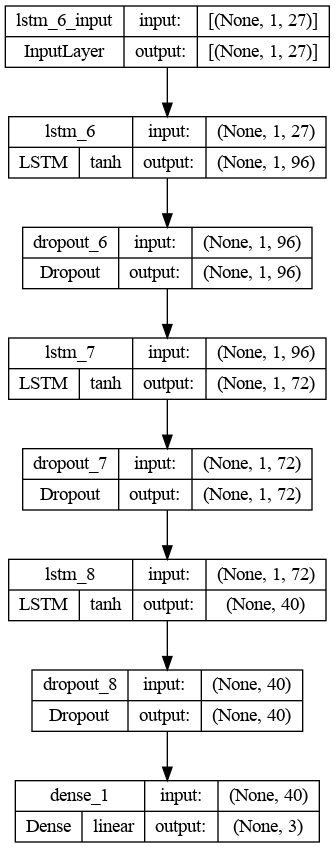

In [19]:
# Plot model architecture
plot_model(
    model_lstm,
    to_file="../plots/model.png",
    show_shapes=True,
    show_layer_names=True,
    show_layer_activations=True,
)

In [20]:
# Learning parameters
d_learning_params = {}
d_learning_params['batch_size'] = 4
d_learning_params['epochs'] = 64
d_learning_params['activation_fn'] = "tanh"
d_learning_params['loss_fn'] = "mse"
d_learning_params['metrics'] = ['mae']
d_learning_params['optimizer'] = "adam"
d_learning_params['scalers'] = [scaler_inputs, scaler_targets]
d_learning_params['feat_names'] = input_columns
d_learning_params['target_names'] = target_columns
d_learning_params['d_train_test'] = d_train_test
d_learning_params['seq_train_test_val'] = {
    "train": {"features": X_train, "targets": y_train},
    "test": {"features": X_test, "targets": y_test}
}
# d_learning_params['layers'] = [64, 50, 32, 16]

Epoch 1/64
95/95 [==============================] - 16s 40ms/step - loss: 0.6886 - mae: 0.6688 - val_loss: 0.1003 - val_mae: 0.2464
Epoch 2/64
95/95 [==============================] - 1s 13ms/step - loss: 0.1715 - mae: 0.3064 - val_loss: 0.0761 - val_mae: 0.2251
Epoch 3/64
95/95 [==============================] - 1s 13ms/step - loss: 0.1305 - mae: 0.2690 - val_loss: 0.0555 - val_mae: 0.1961
Epoch 4/64
95/95 [==============================] - 2s 17ms/step - loss: 0.1091 - mae: 0.2500 - val_loss: 0.0362 - val_mae: 0.1530
Epoch 5/64
95/95 [==============================] - 1s 12ms/step - loss: 0.0947 - mae: 0.2290 - val_loss: 0.0358 - val_mae: 0.1482
Epoch 6/64
95/95 [==============================] - 2s 19ms/step - loss: 0.0984 - mae: 0.2353 - val_loss: 0.0381 - val_mae: 0.1597
Epoch 7/64
95/95 [==============================] - 1s 12ms/step - loss: 0.0905 - mae: 0.2218 - val_loss: 0.0386 - val_mae: 0.1484
Epoch 8/64
95/95 [==============================] - 1s 11ms/step - loss: 0.0799 - 

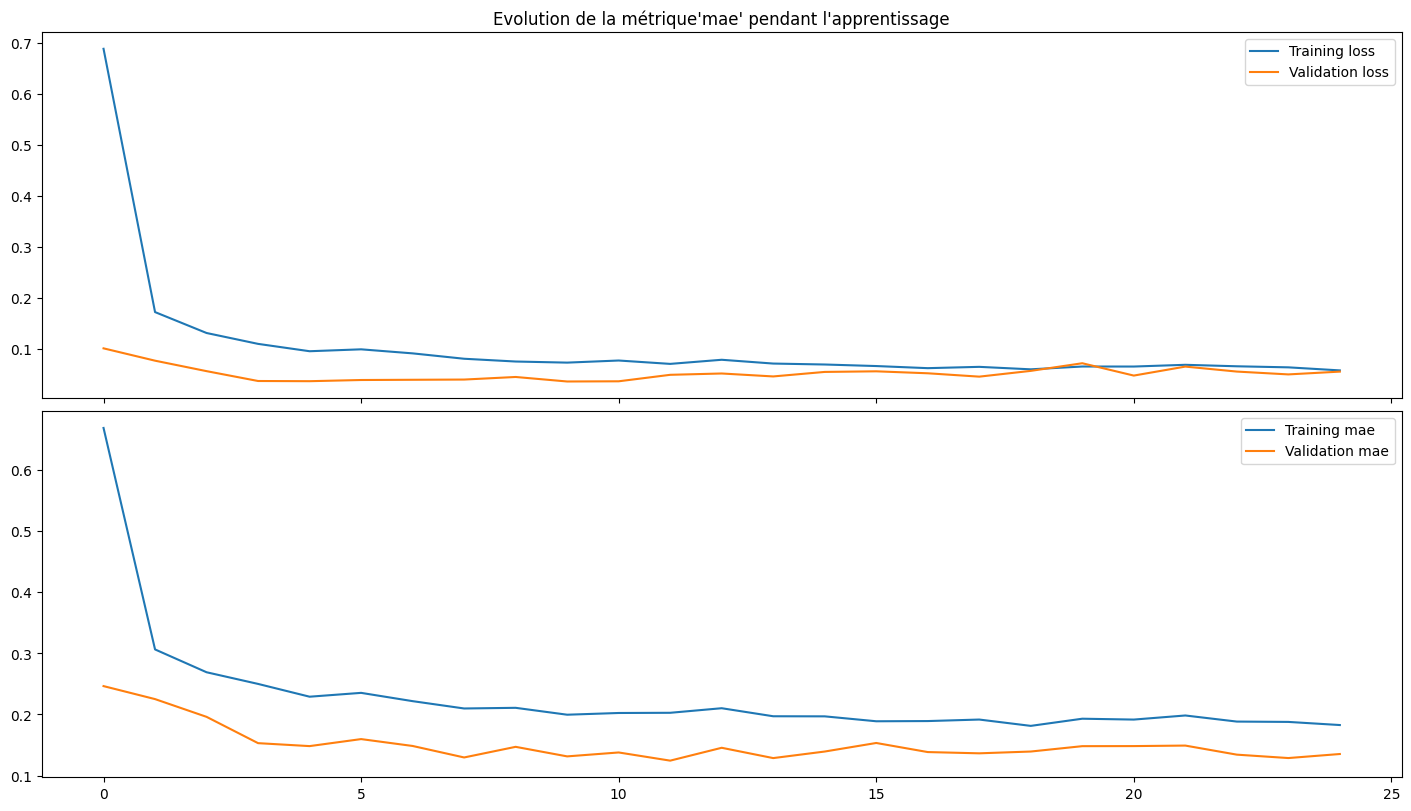

In [21]:
# Get today datetime to create the model file
current_datetime = datetime.now().strftime("%Y%m%d_%H%M%S")
results_dir = os.path.join("../models", "LSTM_MBIOST", "Time_lag_{}".format(seq_length), current_datetime)
params_file = os.path.join(results_dir, "lstm_params_{}.pkl".format(str(current_datetime)))

# Create results directory if not exists
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

# Save learning parameters
with open(params_file, 'wb') as fp:
    pickle.dump(d_learning_params, fp)

model_lstm, scores = train_lstm(X_train, y_train, X_test, y_test, model_lstm, d_learning_params, results_dir)

# Save model scores
d_scores = d_learning_params.copy()
d_scores["scores"] = scores
scores_file = os.path.join(results_dir, "lstm_scores_{}.pkl".format(str(current_datetime)))

print("Model performances")
print("\t --> R2 Score (The model is perfect with a score of 1)")
print("\t \t --> Train set : {}".format(scores['R2']['train']))
print("\t \t --> Test set : {}".format(scores['R2']['test']))
print("\n")
print("\t --> MAE (Mean Absolute Error)")
print("\t \t --> Train set : {}".format(scores['MAE']['train']))
print("\t \t --> Test set : {}".format(scores['MAE']['test']))

# Save learning scores
with open(scores_file, 'wb') as fp:
    pickle.dump(d_scores, fp)

In [22]:
scores_file

'../models/LSTM_MBIOST/Time_lag_1/20231206_183140/lstm_scores_20231206_183140.pkl'

In [23]:
with open(scores_file, 'rb') as f:
    x = pickle.load(f)

In [24]:
x["scores"]

{'R2': {'train': 0.978, 'test': 0.868}, 'MAE': {'train': 0.111, 'test': 0.135}}